#7.6 게이트 순환 신경망 (GRU)
**GRU**
- 게이트 메커니즘이 적용된 RNN 프레임 워크의 한 종류
- LSTM보다 구조가 간단함

##7.6.1 GRU 구조
- LSTM에서 사용하는 망각 게이트와 입력 게이트를 하나로 합친 것이며, 별도의 업데이트 게이트로 구성되어 있음
- 하나의 게이트 컨트롤러가 망각 게이트와 입력 게이트를 모두 제어함
  - 게이트 컨트롤러가 1을 출력 -> 망각 게이트는 열리고 입력 게이트는 닫힘
  - 0을 출력 -> 망각 게이트는 닫히고 입력 게이트는 열림
  - 이전 기억이 저장될 때마다 단계별 입력은 삭제되는 구조
- 출력 게이트가 따로 없어 전체 상태 벡터가 매 단계마다 출력되고, 이전 상태의 어느 부분이 출력될지 제어하는 새로운 게이트 컨트롤러가 별도로 존재함

(1) 망각 게이트
- 과거 정보를 적당히 초기화시키려는 목적으로 시그모이드 함수를 출력으로 이용하여 (0,1) 값을 이전 은닉층에 곱함
- 이전 시점의 은닉층 값에 현시점의 정보에 대한 가중치를 곱한 것

(2) 업데이트 게이트
- 과거와 현재 정보의 최신화 비율을 결정하는 역할 수행
- 시그모이드로 출력된 결과는 현시점의 정보량을 결정하고, 1에서 뺀값을 직전 시점의 은닉층 정보와 곱해줌

(3) 후보군
- 현시점의 정보에 대한 후보군을 계산함
- 과거 은닉층의 정보를 그대로 이용하지 않고 망각 게이트의 결과를 이용해 후보군을 계산함

(4) 은닉층 계산
- 업데이트 게이트 결과와 후보군 결과를 결합해 현시점의 은닉층을 계산함
  - 시그모이드 함수의 결과는 현시점에서 결과에 대한 정보량을 결정
  - 1-시그모이드 함수의 결과는 과거의 정보량을 결정

##7.6.2 GRU 셀 구현
- LSTM 셀과 거의 동일하나 네트워크의 차이점 위주로 공부하는 것이 좋음

In [2]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [3]:
# 데이터 전처리
mnist_transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,),(1.0,))
])

In [4]:
# 데이터셋 내려받기 및 전처리 적용
from torchvision.datasets import MNIST
download_root = '/content/drive/MyDrive/Colab Notebooks/data'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.59MB/s]


In [5]:
# 데이터셋 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# 변수 값 설정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [10]:
# GRU 셀 네트워크
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 3*hidden_size, bias=bias)
    self.h2h = nn.Linear(hidden_size, 3*hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    x = x.view(-1, x.size(1))

    gate_x = self.x2h(x)
    gate_h = self.h2h(hidden)

    gate_x = gate_x.squeeze()
    gate_h = gate_h.squeeze()

    i_r, i_i, i_n = gate_x.chunk(3, 1)
    h_r, h_i, h_n = gate_h.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + (resetgate * h_n))

    hy = newgate + inputgate * (hidden - newgate)

    return hy

- LSTM 셀에는 4를 곱했으나 GRU 셀은 세 개의 게이트가 사용되어 3을 곱함
  - 엄밀히 게이트는 2개이나 탄젠트 활성화 함수가 적용되는 부분을 새로운 게이트로 정의하여 3을 곱하는 것
  

In [11]:
# 전반적인 네트워크 구조
class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(GRUModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    hn = h0[0,:,:]

    for seq in range(x.size(1)):
      hn = self.gru_cell(x[:,seq,:], hn)
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

In [12]:
# 옵티마이저와 손실 함수 설정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
# 모델 학습 및 성능 검증
seq_dim = 28
loss_list=[]
iter=0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0:
      correct = 0
      total = 0
      for images, labels in valid_loader:
        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1, seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct / total
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.6797293424606323. Accuracy: 51.689998626708984
Iteration: 1000. Loss: 0.7661962509155273. Accuracy: 75.62999725341797
Iteration: 1500. Loss: 0.333890438079834. Accuracy: 90.3499984741211
Iteration: 2000. Loss: 0.2211846262216568. Accuracy: 93.4000015258789
Iteration: 2500. Loss: 0.10917289555072784. Accuracy: 95.08000183105469
Iteration: 3000. Loss: 0.09789103269577026. Accuracy: 95.91000366210938
Iteration: 3500. Loss: 0.030050702393054962. Accuracy: 96.61000061035156
Iteration: 4000. Loss: 0.23502781987190247. Accuracy: 96.41000366210938
Iteration: 4500. Loss: 0.07298442721366882. Accuracy: 97.37000274658203
Iteration: 5000. Loss: 0.006642625201493502. Accuracy: 97.47000122070312
Iteration: 5500. Loss: 0.0548429936170578. Accuracy: 97.47000122070312
Iteration: 6000. Loss: 0.02938760444521904. Accuracy: 97.76000213623047
Iteration: 6500. Loss: 0.016405105590820312. Accuracy: 97.69999694824219
Iteration: 7000. Loss: 0.019580060616135597. Accuracy: 97.73000335693

In [16]:
# 테스트 데이터셋을 이용한 모델 예측
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction='sum')
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [17]:
# 모델 예측 결과
test_loss, test_acc = evaluate(model, test_loader)
print('Test Loss: %5.2f | Test Acc: %5.2f' % (test_loss, test_acc))

Test Loss:  0.06 | Test Acc:  0.98


##7.6.3 GRU 계층 구현

In [18]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
!rm -rf /content/drive

In [23]:
# 데이터셋 불러오기
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/SBUX.csv')
print(data.dtypes)

Mounted at /content/drive
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [24]:
# 인덱스 설정 및 데이터 타입 변경
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [25]:
# 훈련과 레이블 데이터셋 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [26]:
# 훈련과 테스트 데이터셋 정규화
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ms.fit_transform(X)
y_ms = ss.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [27]:
# 데이터셋 형태 변경
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [31]:
# GRU 모델의 네트워크
class GRU(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    out, (hn) = self.gru(x, (h_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [32]:
# 옵티마이저와 손실 함수 지정
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
# 모델 학습
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 100 ==0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.12508
Epoch: 100, loss: 1.08535
Epoch: 200, loss: 1.08255
Epoch: 300, loss: 1.08056
Epoch: 400, loss: 1.07800
Epoch: 500, loss: 1.07314
Epoch: 600, loss: 1.06257
Epoch: 700, loss: 1.04237
Epoch: 800, loss: 1.00660
Epoch: 900, loss: 0.95319


In [35]:
# 그래프 출력을 위한 전처리
df_x_ms = ms.transform(data.iloc[:,:-1])
df_y_ss = ss.transform(data.iloc[:,-1:])

df_x_ms = Variable(torch.Tensor(df_x_ms))
df_y_ss = Variable(torch.Tensor(df_y_ss))
df_x_ms = torch.reshape(df_x_ms, (df_x_ms.shape[0], 1, df_x_ms.shape[1]))

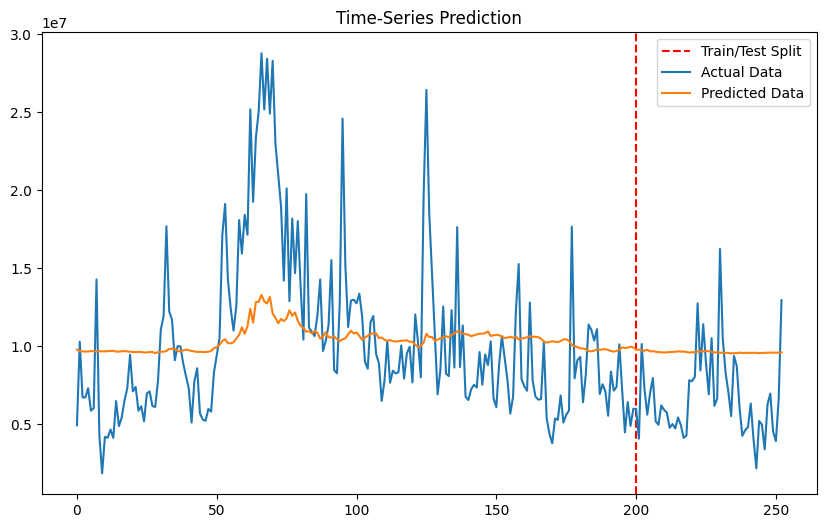

In [36]:
# 모델 예측 결과 출력
model.eval()
with torch.no_grad():
    train_predict = model(df_x_ms.to(device))

predicted = train_predict.cpu().numpy()
label_y = df_y_ss.cpu().numpy()

predicted = ss.inverse_transform(predicted)
label_y = ss.inverse_transform(label_y)


plt.figure(figsize=(10, 6))
plt.axvline(x=200, color='r', linestyle='--', label='Train/Test Split')

plt.plot(label_y, label="Actual Data")
plt.plot(predicted, label="Predicted Data")

plt.title("Time-Series Prediction")
plt.legend()
plt.show()


# 7.7 양방향 RNN
- 이전 시점의 데이터뿐만 아니라 이후 시점의 데이터도 함께 활용하여 출력 값을 예측하고자 하는 것

##7.7.1 양방향 RNN 구조
- 하나의 출력 값을 예측하는데 메모리 셀 두 개를 사용함
  - 첫 번째 메모리 셀: 이전 시점의 은닉 상태를 전달받아 현재의 은닉 상태를 계산
  - 두 번째 메모리 셀: 다음 시점의 은닉 상태를 전달받아 현재의 은닉 상태를 계산
- 이 값 두 개를 모두 출력 층에서 출력 값을 예측하는데 사용함


##7.7.2 양방향 LSTM 구현

In [39]:
# 모델을 생성하고 학습
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ms.fit_transform(X)
y_ms = ss.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [45]:
# 모델의 네트워크
class biLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(biLSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
    out, (hn, cn) = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:,-1,:])
    out = self.relu(out)
    return out

- bidirectional=True: 양방향 LSTM을 사용하겠다는 의미
  - 양방향 RNN, 양방향 GRU에 모두 해당함

In [46]:
# 모델 학습
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()

  loss = criterion(outputs, y_train_tensors)
  loss.backward()
  optimizer.step()
  if epoch % 100 ==0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.08669
Epoch: 100, loss: 1.08143
Epoch: 200, loss: 1.07636
Epoch: 300, loss: 1.07143
Epoch: 400, loss: 1.06658
Epoch: 500, loss: 1.06170
Epoch: 600, loss: 1.05672
Epoch: 700, loss: 1.05150
Epoch: 800, loss: 1.04594
Epoch: 900, loss: 1.03992


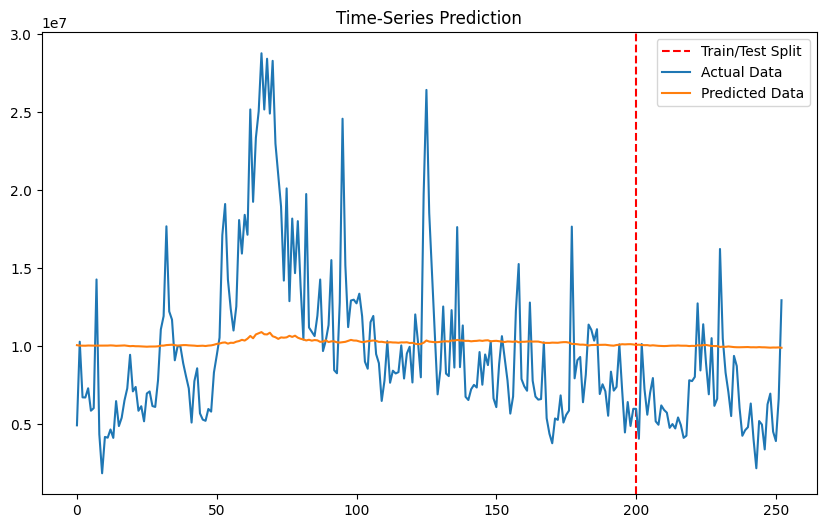

In [49]:
# 모델 평가
df_x_ms = ms.transform(data.iloc[:,:-1])
df_y_ss = ss.transform(data.iloc[:,-1:])

df_x_ms = Variable(torch.Tensor(df_x_ms))
df_y_ss = Variable(torch.Tensor(df_y_ss))
df_x_ms = torch.reshape(df_x_ms, (df_x_ms.shape[0], 1, df_x_ms.shape[1]))

train_predict = model(df_x_ms.to(device))
predicted = train_predict.detach().cpu().numpy()
label_y = df_y_ss.cpu().numpy()

predicted = ss.inverse_transform(predicted)
label_y = ss.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, color='r', linestyle='--', label='Train/Test Split')

plt.plot(label_y, label="Actual Data")
plt.plot(predicted, label="Predicted Data")

plt.title("Time-Series Prediction")
plt.legend()
plt.show()